True
[1]
tensor(0.0004)


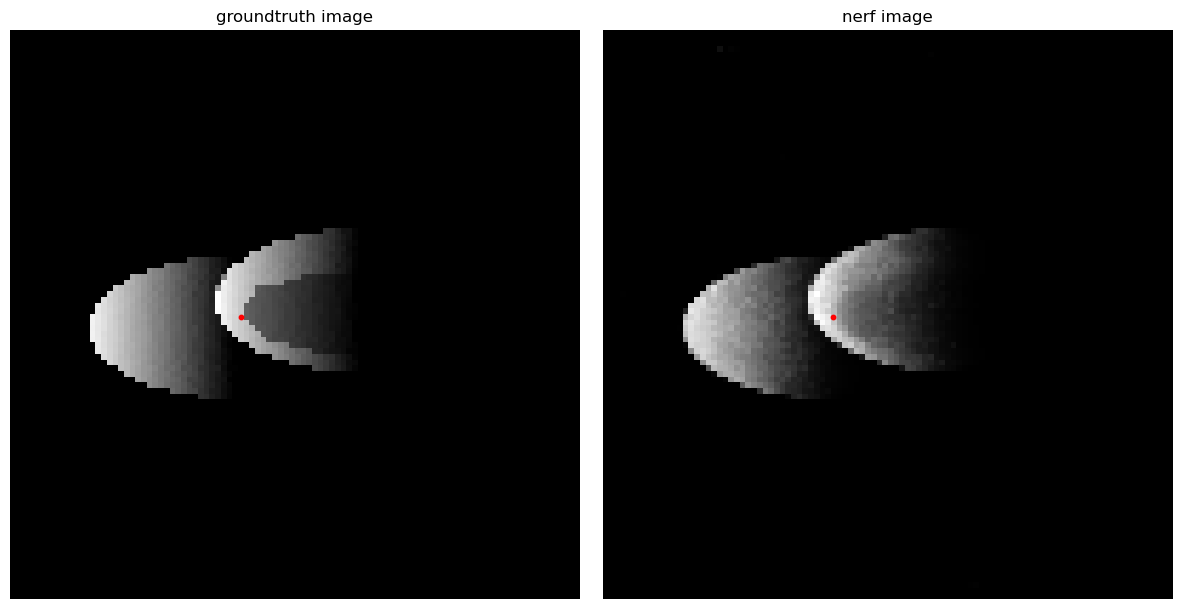

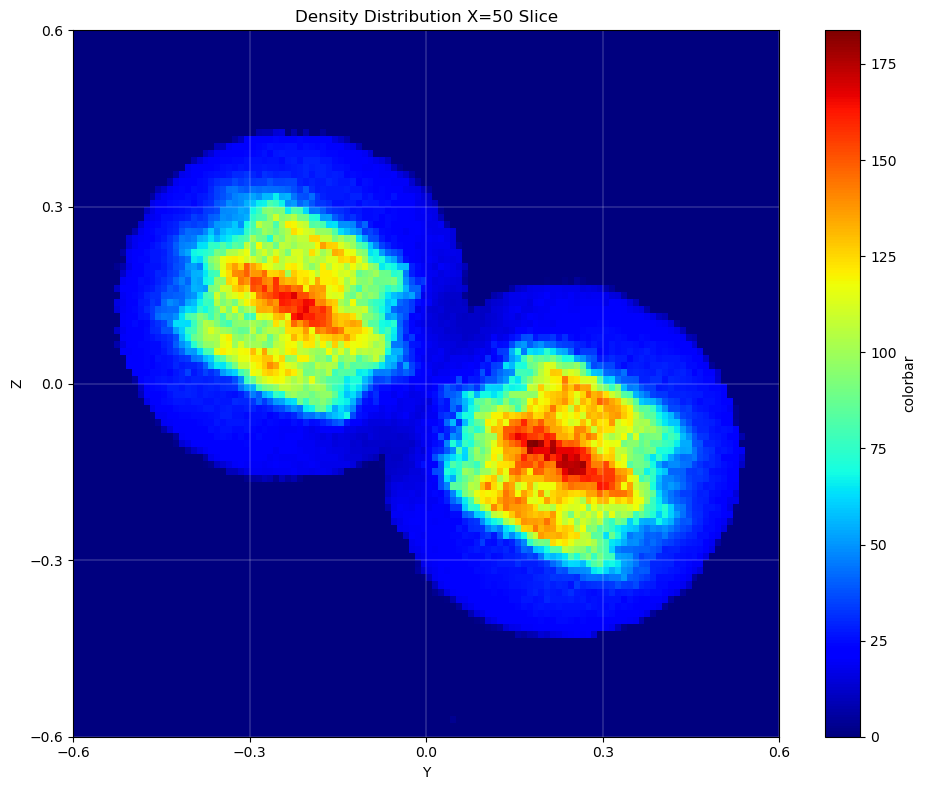

In [14]:
# 变换位置编码后的验证程序
import torch
import numpy as np
# torch.autograd.set_detect_anomaly(True)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import os
import random
import matplotlib.pyplot as plt
import re
from matplotlib.widgets import Slider
from skimage import measure

import plotly.graph_objects as go

class NeRF(nn.Module):
    def __init__(self, D=8, W=256, input_ch=3, input_ch_views=3, output_ch=2, skips=[4], use_viewdirs=True):
        """
        D: 深度，多少层网络
        W: 网络内的channel 宽度
        input_ch: xyz的宽度
        input_ch_views: direction的宽度
        output_ch: 这个参数尽在 use_viewdirs=False的时候会被使用
        skips: 类似resnet的残差连接，表明在第几层进行连接
        use_viewdirs:

        网络输入已经被位置编码后的参数，输入为[64*bs,90]，输出为[64*bs，2]，一位是体积密度，一位是后向散射系数
        """
        super(NeRF, self).__init__()
        self.D = D
        self.W = W
        self.input_ch = input_ch
        self.input_ch_views = input_ch_views
        self.skips = skips
        self.use_viewdirs = use_viewdirs

        # 神经网络,MLP
        # 3D的空间坐标进入的网络
        # 这个跳跃连接层是直接拼接，不是resnet的那种相加
        self.pts_linears = nn.ModuleList(
            [nn.Linear(input_ch, W)] + [nn.Linear(W, W) if i not in self.skips else nn.Linear(W + input_ch, W) for i in
                                        range(D - 1)])

        # 这里channel削减一半 128
        ### Implementation according to the official code release (https://github.com/bmild/nerf/blob/master/run_nerf_helpers.py#L104-L105)
        self.views_linears = nn.ModuleList([nn.Linear(input_ch_views + W, W // 2)])
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        if use_viewdirs:
            # 特征
            self.feature_linear = nn.Linear(W, W)
            # 体积密度,一个值
            self.alpha_linear = nn.Linear(W, 1)
            # 后向散射系数，一个值
            self.rho_linear = nn.Linear(W // 2, 1)
        else:
            self.output_linear = nn.Linear(W, output_ch)

    def forward(self, x):
        # x [bs*64, 90]
        # input_pts [bs*64, 63]
        # input_views [bs*64,27]
        input_pts, input_views = torch.split(x, [self.input_ch, self.input_ch_views], dim=-1)

        h = input_pts

        for i, l in enumerate(self.pts_linears):

            h = self.pts_linears[i](h)
            h = F.relu(h)
            # 第四层后相加
            if i in self.skips:
                h = torch.cat([input_pts, h], -1)

        if self.use_viewdirs:
            # alpha只与xyz有关
            alpha = self.alpha_linear(h)
            feature = self.feature_linear(h)
            # rho与xyz和d都有关
            h = torch.cat([feature, input_views], -1)

            for i, l in enumerate(self.views_linears):
                h = self.views_linears[i](h)
                h = F.relu(h)

            sigma = self.rho_linear(h)
            alpha = self.relu(alpha) 
            sigma = self.relu(sigma)
            outputs = torch.cat([alpha, sigma], -1)
        else:
            outputs = self.output_linear(h)

        return outputs


def batchrender(omega,LOS,model,doppler_num):
    '''
    omega为一个[bs,3]变量，指向旋转轴方向，模值为角速度
    LOS为一个[bs,3]变量，方向为视线方向指向物体，模值为1
    model是nerf模型，将一个已经进行位置编码后的位置和视线向量输入进model,可以返回这个位置的体积密度和散射系数
    doppler_num为一个[bs]变量，确定了渲染后光线所在的位置
    '''
    # 确定回波波长
    fc = torch.tensor([9.7e9]).to(device)
    c = torch.tensor([299792458]).to(device)
    lambda0 = c/fc
    # 确定网格参数
    distance_max = 0.60
    distance_min = -0.60
    distance_gap = 100
    doppler_max = 0.15
    doppler_min = -0.15
    doppler_gap = 100
    n_max = 0.60
    n_min = -0.60
    n_gap = 120
    # 确定输入batch_size
    batch_size,len = omega.shape
    # 确定每个batch_size输入的投影平面
    omega_norm = torch.linalg.norm(omega,dim = 1)
    omega_normlize = omega/omega_norm.unsqueeze(1)
    Doppler_vector = torch.cross(LOS,omega,dim=1)
    LOSomega_sin_angel = torch.linalg.norm(Doppler_vector,dim=1)/(torch.linalg.norm(omega,dim=1)*torch.linalg.norm(LOS,dim=1))
    Doppler_vector = Doppler_vector/torch.linalg.norm(Doppler_vector,dim = 1).unsqueeze(1)
    # 绘制投影坐标
    distance = torch.linspace(distance_min,distance_max,distance_gap).to(device)
    distance = distance.repeat(batch_size,1)
    distance_delta = torch.tensor((distance_max-distance_min)/distance_gap).to(device)
    doppler = torch.linspace(doppler_min,doppler_max,doppler_gap).repeat(batch_size,1).to(device)
    doppler = doppler*4/LOSomega_sin_angel.unsqueeze(1)
    distance_map = distance.unsqueeze(2)*LOS.unsqueeze(1)
    doppler_map = doppler.unsqueeze(2)*Doppler_vector.unsqueeze(1)
    # 确定投影平面法向量
    n = torch.cross(LOS,Doppler_vector,dim=1)
    n = n/torch.linalg.norm(n,dim = 1).unsqueeze(1)
    # 对投影平面法向量进行随机采样
    n_array = torch.linspace(n_min,n_max,n_gap+1).to(device)
    n_array = n_array.repeat(batch_size,distance_gap,1)
    # 非随机采样
    # n_random_array = n_array[:,:,0:-1] + (n_array[:,:,1:] - n_array[:,:,0:-1])*torch.ones(batch_size,distance_gap,n_gap).to(device)*0.5
    # # 随机采样
    n_random_array = n_array[:,:,0:-1] + (n_array[:,:,1:] - n_array[:,:,0:-1])*torch.rand(batch_size,distance_gap,n_gap).to(device)
    n_random_map = n_random_array.unsqueeze(3)*n.unsqueeze(1).unsqueeze(2)
    # 计算不同随机法向量之间的间隔
    start_n = n.unsqueeze(1).unsqueeze(2)*torch.tensor(n_min).float().to(device)
    start_n = start_n * torch.ones(batch_size,distance_gap,1,3).to(device)
    n_random_map_temp = torch.cat((start_n,n_random_map),dim=2)
    n_delta = torch.norm(n_random_map_temp[:,:,0:-1,:]-n_random_map,dim=3)

    # 计算所有需要输入网络的坐标
    code_flag = 1
    if code_flag == 1:
        xyz = doppler_map[torch.arange(batch_size),doppler_num,:].unsqueeze(1).unsqueeze(2) + distance_map.unsqueeze(2) + n_random_map
        xyz_coding = positon_code_xyz(xyz)
        LOS_coding = position_code_LOS(LOS)
        LOS_coding = ((LOS_coding.unsqueeze(1).unsqueeze(2))*torch.ones(batch_size,distance_gap,n_gap,27).to(device)).view(-1,27)
        xyzLOS_coding = torch.cat((xyz_coding,LOS_coding),dim=1)
    else:
        xyz = doppler_map[torch.arange(batch_size),doppler_num,:].unsqueeze(1).unsqueeze(2) + distance_map.unsqueeze(2) + n_random_map
        xyz_coding = xyz.view(-1,3)
        LOS_coding = ((LOS.unsqueeze(1).unsqueeze(2))*torch.ones(batch_size,distance_gap,n_gap,3).to(device)).view(-1,3)
        print(LOS_coding)
        xyzLOS_coding = torch.cat((xyz_coding,LOS_coding),dim=1)
    output = model(xyzLOS_coding)
    output = output.view(batch_size,distance_gap,n_gap,2)
    render_equaltion = 3
    if render_equaltion == 0:
        Ti = torch.cumprod(torch.exp(-output[:,:,:,0]*distance_delta),dim=1)
        distance_profile = torch.sum(output[:,:,:,0]*(1-torch.exp(-output[:,:,:,1]*n_delta))*Ti,dim=2)
    elif render_equaltion == 1:
        Ti = torch.cumprod(torch.exp(-output[:,:,:,0]**2*distance_delta),dim=1)
        distance_profile = torch.sum(output[:,:,:,0]*output[:,:,:,1]*n_delta*Ti,dim=2)
    elif render_equaltion == 2:
        Ti = torch.cumprod(torch.exp(-output[:,:,:,0]*distance_delta),dim=1)
        # 将Ti的第1维首增加一个1，并去除最后一维，方便计算
        Ti = torch.cat((torch.ones(batch_size,1,n_gap).to(device),Ti),dim=1)[:,:-1,:]
        # 计算alpha_i
        alphai = 1-torch.exp(-output[:,:,:,0]*distance_delta)
        distance_profile = torch.sum(alphai*output[:,:,:,1]*n_delta*Ti,dim=2)
    elif render_equaltion == 3:
        Ti = torch.cumprod(1-output[:,:,:,0],dim=1)
        # 将Ti的第1维首增加一个1，并去除最后一维，方便计算
        Ti = torch.cat((torch.ones(batch_size,1,n_gap).to(device),Ti),dim=1)[:,:-1,:]
        distance_profile = torch.sum(output[:,:,:,0]*output[:,:,:,1]*n_delta*Ti,dim=2)


    return distance_profile,output[:,:,:,1]

def positon_code_xyz(xyz):
    code_len = 10
    batch_size,distance,n,dimension = xyz.shape
    xyz = xyz.view(-1,dimension)
    xyz = xyz
    position_coding = torch.zeros_like(xyz).to(device)
    position_coding = position_coding.repeat(1,code_len*2)
    div_term = 2 ** torch.arange(0,code_len,step=1).to(device)
    position_coding[:,0::2] = torch.sin((xyz.unsqueeze(1) * math.pi * div_term.unsqueeze(1).unsqueeze(0)).view(batch_size*distance*n,-1))
    position_coding[:,1::2] = torch.cos((xyz.unsqueeze(1) * math.pi * div_term.unsqueeze(1).unsqueeze(0)).view(batch_size*distance*n,-1))
    position_coding = torch.cat((xyz,position_coding),dim=1)
    
    return position_coding

def position_code_LOS(LOS):
    code_len = 4
    batch_size,dimension = LOS.shape
    position_coding = torch.zeros_like(LOS).to(device)
    position_coding = position_coding.repeat(1,code_len*2)
    div_term = 2 ** torch.arange(0,code_len,step=1).to(device)
    position_coding[:,0::2] = torch.sin((LOS.unsqueeze(1) * div_term.unsqueeze(1).unsqueeze(0)).view(batch_size,-1))
    position_coding[:,1::2] = torch.cos((LOS.unsqueeze(1) * div_term.unsqueeze(1).unsqueeze(0)).view(batch_size,-1))
    position_coding = torch.cat((LOS,position_coding),dim=1)

    return position_coding

def picture_sample(images,LOS_dirs,omegas,batch_size,image_hight = 100,image_width = 100, image_num = 150):
    temp_num = random.sample(range(image_num),1)
    # temp_num = [75]
    print(temp_num)
    temp = [t*image_hight for t in temp_num] + np.arange(100)
    data_num = [x//image_hight for x in temp]
    doppler_numbers = [x % image_hight for x in temp]
    
    LOS_dirs_batch = [LOS_dirs[x] for x in data_num]
    omegas_batch = [omegas[x] for x in data_num]
    range_profile_batch = [images[x][y,:] for x,y in zip(data_num,doppler_numbers)]

    omegas_batch_tensor = torch.stack(omegas_batch).to(device)
    LOS_dirs_batch_tensor = torch.stack(LOS_dirs_batch).to(device)
    range_profile_batch_tensor = torch.stack(range_profile_batch).to(device)
    doppler_profil_num_tensor = torch.tensor(doppler_numbers).long().to(device)

    # range_image = range_profile_batch_tensor.detach().cpu()
    # plt.imshow(range_image)
    # plt.show()
    
    return omegas_batch_tensor,LOS_dirs_batch_tensor,range_profile_batch_tensor,doppler_profil_num_tensor

def natural_sort_key(s):
    # 分割字符串中的数字并将它们转换为整数
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', s)]

def loaddata(folder_path):
    '''
    输入文件夹路径，输出数据集
    '''
    # 获取文件夹中的所有文件和子文件夹
    items = os.listdir(folder_path)
    # 过滤出所有文件（排除子文件夹）
    files = [item for item in items if os.path.isfile(os.path.join(folder_path, item)) and item.endswith('.npz')]
    files_sorted = sorted(files, key=natural_sort_key)
    #载入数据
    images = []
    LOS_dirs = []
    omegas = []
    for file in files_sorted:
        full_path = folder_path+"/"+file
        data = np.load(full_path)
        image = torch.from_numpy(data['image']).to(device)
        LOS_dir = torch.from_numpy(data['LOS']).to(device)
        omega = torch.from_numpy(data['rotation_axis']).to(device)
        images.append(image)
        LOS_dirs.append(LOS_dir)
        omegas.append(omega)
    return images,LOS_dirs,omegas




device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

model = NeRF(input_ch = 63, input_ch_views = 27, use_viewdirs = True).to(device)
model.load_state_dict(torch.load('/DATA/disk1/Instant-ngp/model_unsurf/experiment02/model_state_dict.pth'))
model.eval()

omega_real = math.pi/900

folder_path = '/DATA/disk1/Instant-ngp/dataset/sys_data/contact_ball/test01'
images,LOS_dirs,omegas = loaddata(folder_path)

omegas_batch_tensor,LOS_dirs_batch_tensor,range_profile_batch_tensor,doppler_profil_num_tensor = picture_sample(images,LOS_dirs,omegas,batch_size = 40)
distance_profile_batch,output = batchrender(omegas_batch_tensor*omega_real,LOS_dirs_batch_tensor,model,doppler_profil_num_tensor)

# print(LOS_dirs)
# print(LOS_dirs_batch_tensor)

range_image1 = distance_profile_batch.detach().cpu()
# plt.figure()
# plt.imshow(range_image1)
# plt.colorbar()


range_image2 = range_profile_batch_tensor.detach().cpu()
# plt.figure()
# plt.imshow(range_image2)
# plt.colorbar()
# plt.show()
# 创建子图
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# 图像1
axes[0].imshow(range_image2,cmap='gray')
axes[0].set_title("groundtruth image")
axes[0].axis('off')

# 图像2
axes[1].imshow(range_image1,cmap='gray')
axes[1].set_title("nerf image")
axes[1].axis('off')

# 在两张图片上标注某一个点的位置
axes[0].scatter(40, 50, c='r', s=10)
axes[1].scatter(40, 50, c='r', s=10)

# 计算图像之间的MSE
mse = ((range_image1 - range_image2) ** 2).mean()
print(mse)
plt.tight_layout()
plt.show()

ray_distribution = output.detach().cpu().numpy()
# ray_distribution_one = ray_distribution[40,78,:]

# # 绘制图像
# plt.figure()
# plt.plot(ray_distribution_one)
# plt.show()


# 1. 交互式切片可视化
def visualize_slices(density_volume):
    """创建交互式切片可视化"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # 初始切片位置
    x_idx, y_idx, z_idx = density_volume.shape[0]//2, density_volume.shape[1]//2, density_volume.shape[2]//2
    
    # 创建切片显示
    x_slice = axes[0].imshow(density_volume[x_idx, :, :], cmap='viridis')
    axes[0].set_title(f'YZ平面 (X={x_idx})')
    y_slice = axes[1].imshow(density_volume[:, y_idx, :], cmap='viridis')
    axes[1].set_title(f'XZ平面 (Y={y_idx})')
    z_slice = axes[2].imshow(density_volume[:, :, z_idx], cmap='viridis')
    axes[2].set_title(f'XY平面 (Z={z_idx})')
    
    # 添加滑块
    ax_x = plt.axes([0.1, 0.02, 0.8, 0.03])
    ax_y = plt.axes([0.1, 0.06, 0.8, 0.03])
    ax_z = plt.axes([0.1, 0.10, 0.8, 0.03])
    
    s_x = Slider(ax_x, 'X切片', 0, density_volume.shape[0]-1, valinit=x_idx, valstep=1)
    s_y = Slider(ax_y, 'Y切片', 0, density_volume.shape[1]-1, valinit=y_idx, valstep=1)
    s_z = Slider(ax_z, 'Z切片', 0, density_volume.shape[2]-1, valinit=z_idx, valstep=1)
    
    def update(val):
        x_idx = int(s_x.val)
        y_idx = int(s_y.val)
        z_idx = int(s_z.val)
        
        x_slice.set_data(density_volume[x_idx, :, :])
        axes[0].set_title(f'YZ平面 (X={x_idx})')
        y_slice.set_data(density_volume[:, y_idx, :])
        axes[1].set_title(f'XZ平面 (Y={y_idx})')
        z_slice.set_data(density_volume[:, :, z_idx])
        axes[2].set_title(f'XY平面 (Z={z_idx})')
        fig.canvas.draw_idle()
    
    s_x.on_changed(update)
    s_y.on_changed(update)
    s_z.on_changed(update)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.25)
    plt.show()

# 2. Marching Cubes可视化
def visualize_isosurfaces(density_volume, threshold_ratio=0.5):
    """使用Marching Cubes创建等值面可视化"""
    # 计算阈值
    vmin, vmax = density_volume.min(), density_volume.max()
    threshold = vmin + (vmax - vmin) * threshold_ratio
    
    # 提取等值面
    verts, faces, normals, values = measure.marching_cubes(density_volume, threshold)
    
    # 调整顶点坐标到[-0.6, 0.6]范围
    verts = verts / density_volume.shape[0] * 1.2 - 0.6
    
    # 创建3D图
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # 绘制等值面
    mesh = ax.plot_trisurf(verts[:, 0], verts[:, 1], faces, verts[:, 2],color='cyan', alpha=0.7, shade=True)

    filename="mesh_export25.obj"

    with open(filename, 'w') as f:
        # 写入文件头
        f.write(f"# OBJ文件由NeRF模型生成\n")
        f.write(f"# 顶点数: {verts.shape[0]}\n")
        f.write(f"# 面数: {faces.shape[0]}\n\n")
        
        # 写入顶点
        for v in verts:
            f.write(f"v {v[0]} {v[1]} {v[2]}\n")
        
        # 写入面 (OBJ索引从1开始)
        for face in faces:
            # 索引加1转换为OBJ格式
            f.write(f"f {face[0]+1} {face[1]+1} {face[2]+1}\n")
        
    print(f"OBJ文件导出成功: {filename}")
    
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'密度等值面 (阈值: {threshold:.4f})')
    
    ax.set_xlim([-1.0, 1.0])
    ax.set_ylim([-1.0, 1.0])
    ax.set_zlim([-1.0, 1.0])
    
    plt.tight_layout()
    plt.show()

# 3. 多阈值等值面可视化
def visualize_multi_isosurfaces(density_volume, thresholds=[0.3, 0.5, 0.7]):
    """使用多个阈值创建嵌套等值面可视化"""
    vmin, vmax = density_volume.min(), density_volume.max()
    thresholds = [vmin + (vmax - vmin) * t for t in thresholds]
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    colors = ['blue', 'cyan', 'green']
    alphas = [0.3, 0.5, 0.7]
    
    for i, threshold in enumerate(thresholds):
        verts, faces, normals, values = measure.marching_cubes(density_volume, threshold)
        verts = verts / density_volume.shape[0] * 1.0 - 0.6
        
        mesh = ax.plot_trisurf(verts[:, 0], verts[:, 1], faces, verts[:, 2],color=colors[i], alpha=alphas[i], shade=True)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('多阈值密度等值面')
    
    
    ax.set_xlim([-0.6, 0.6])
    ax.set_ylim([-0.6, 0.6])
    ax.set_zlim([-0.6, 0.6])
    
    plt.tight_layout()
    plt.show()

def visualize_plotly_isosurface(density_volume, threshold_ratio=0.3, filename=None):
    """
    使用Plotly创建交互式3D等值面可视化
    
    参数:
        density_volume: 3D密度体积数组
        threshold_ratio: 阈值比例 (0.0-1.0)
        filename: 可选，保存为HTML文件的路径
    """
    # 计算阈值
    vmin, vmax = density_volume.min(), density_volume.max()
    threshold = vmin + (vmax - vmin) * threshold_ratio
    
    print(f"正在提取等值面，阈值: {threshold:.4f}...")
    # 提取等值面
    verts, faces, normals, values = measure.marching_cubes(density_volume, threshold)
    
    # 调整顶点坐标到[-0.6, 0.6]范围
    verts = verts / density_volume.shape[0] * 1.2 - 0.6
    
    # 创建Plotly的Mesh3d对象
    fig = go.Figure(data=[go.Mesh3d(
        x=verts[:, 0],
        y=verts[:, 1],
        z=verts[:, 2],
        i=faces[:, 0],
        j=faces[:, 1],
        k=faces[:, 2],
        opacity=0.8,
        colorscale='Blues',
        intensity=values,
        showscale=True
    )])
    
    # 设置布局
    fig.update_layout(
        title=f'NeRF密度等值面 (阈值: {threshold:.4f})',
        scene=dict(
            xaxis=dict(range=[-0.6, 0.6], title='X'),
            yaxis=dict(range=[-0.6, 0.6], title='Y'),
            zaxis=dict(range=[-0.6, 0.6], title='Z'),
            aspectmode='cube'
        ),
        width=900,
        height=900,
    )
    
    # 导出OBJ文件(如果需要)
    if filename and filename.endswith('.obj'):
        with open(filename, 'w') as f:
            f.write(f"# 顶点数: {verts.shape[0]}\n")
            f.write(f"# 面数: {faces.shape[0]}\n\n")
            
            for v in verts:
                f.write(f"v {v[0]} {v[1]} {v[2]}\n")
            
            for face in faces:
                f.write(f"f {face[0]+1} {face[1]+1} {face[2]+1}\n")
        print(f"OBJ文件导出成功: {filename}")
    
    # 保存HTML(如果需要)
    if filename and filename.endswith('.html'):
        fig.write_html(filename)
        print(f"交互式HTML文件导出成功: {filename}")
        
    return fig

def visualize_plotly_multi_isosurfaces(density_volume, thresholds=[0.3, 0.5, 0.7], colorscales=['Blues', 'Greens', 'Reds'], filename=None):
    """
    使用Plotly创建多个交互式3D等值面可视化
    
    参数:
        density_volume: 3D密度体积数组
        thresholds: 阈值比例列表
        colorscales: 颜色映射列表
        filename: 可选，保存为HTML文件的路径
    """
    fig = go.Figure()
    vmin, vmax = density_volume.min(), density_volume.max()
    
    # 为每个阈值添加一个等值面
    for i, threshold_ratio in enumerate(thresholds):
        threshold = vmin + (vmax - vmin) * threshold_ratio
        verts, faces, normals, values = measure.marching_cubes(density_volume, threshold)
        verts = verts / density_volume.shape[0] * 1.2 - 0.6
        
        opacity = 0.9 - i * 0.2  # 随着阈值增加，透明度增加
        
        fig.add_trace(go.Mesh3d(
            x=verts[:, 0],
            y=verts[:, 1],
            z=verts[:, 2],
            i=faces[:, 0],
            j=faces[:, 1],
            k=faces[:, 2],
            opacity=max(0.3, opacity),
            colorscale=colorscales[i % len(colorscales)],
            intensity=values,
            showscale=True,
            name=f'阈值: {threshold:.4f}'
        ))
    
    fig.update_layout(
        title='NeRF密度多阈值等值面',
        scene=dict(
            xaxis=dict(range=[-0.6, 0.6], title='X'),
            yaxis=dict(range=[-0.6, 0.6], title='Y'),
            zaxis=dict(range=[-0.6, 0.6], title='Z'),
            aspectmode='cube'
        ),
        width=900,
        height=900,
    )
    
    if filename and filename.endswith('.html'):
        fig.write_html(filename)
        print(f"交互式HTML文件导出成功: {filename}")
        
    return fig

# 添加一个结合切片和等值面的可视化函数
# def visualize_plotly_combined(density_volume, threshold_ratio=0.3, slice_pos=None, filename=None):
    """
    结合等值面和切片的可视化
    
    参数:
        density_volume: 3D密度体积数组
        threshold_ratio: 阈值比例
        slice_pos: 切片位置[x, y, z]，如果为None则使用中间位置
        filename: 可选的HTML输出文件名
    """
    if slice_pos is None:
        slice_pos = [density_volume.shape[0]//2, 
                    density_volume.shape[1]//2, 
                    density_volume.shape[2]//2]
    
    fig = go.Figure()
    vmin, vmax = density_volume.min(), density_volume.max()
    threshold = vmin + (vmax - vmin) * threshold_ratio
    
    # 添加等值面
    verts, faces, normals, values = measure.marching_cubes(density_volume, threshold)
    verts = verts / density_volume.shape[0] * 1.2 - 0.6
    
    fig.add_trace(go.Mesh3d(
        x=verts[:, 0],
        y=verts[:, 1],
        z=verts[:, 2],
        i=faces[:, 0],
        j=faces[:, 1],
        k=faces[:, 2],
        opacity=0.7,
        colorscale='Blues',
        intensity=values,
        showscale=True,
        name=f'等值面: {threshold:.4f}'
    ))
    
    # 添加X、Y、Z切片
    x, y, z = np.meshgrid(
        np.linspace(-0.6, 0.6, density_volume.shape[0]),
        np.linspace(-0.6, 0.6, density_volume.shape[1]),
        np.linspace(-0.6, 0.6, density_volume.shape[2]),
        indexing='ij'
    )
    
    # X切片
    fig.add_trace(go.Volume(
        x=x.flatten(),
        y=y.flatten(),
        z=z.flatten(),
        value=density_volume.flatten(),
        opacity=0.2,
        surface_count=1,
        colorscale='Viridis',
        caps=dict(x=dict(show=False), y=dict(show=False), z=dict(show=False)),
        slices=dict(
            x=dict(show=True, locations=[x[slice_pos[0],0,0]]),
            y=dict(show=True, locations=[y[0,slice_pos[1],0]]),
            z=dict(show=True, locations=[z[0,0,slice_pos[2]]])
        ),
        name='密度切片'
    ))
    
    fig.update_layout(
        title='NeRF密度等值面与切片',
        scene=dict(
            xaxis=dict(range=[-0.6, 0.6], title='X'),
            yaxis=dict(range=[-0.6, 0.6], title='Y'),
            zaxis=dict(range=[-0.6, 0.6], title='Z'),
            aspectmode='cube'
        ),
        width=900,
        height=900,
    )
    
    if filename and filename.endswith('.html'):
        fig.write_html(filename)
        print(f"交互式HTML文件导出成功: {filename}")
        
    return fig

def visualize_slice_imagesc(density_volume, slice_direction='z', slice_index=None, 
                           cmap='viridis', figsize=(10, 8), title=None, 
                           save_path=None, scale_factor=1.2, offset=-0.6):
    """
    使用类似MATLAB imagesc的方式可视化密度体积的单个切片
    
    参数:
        density_volume: 3D密度体积数组
        slice_direction: 切片方向，'x', 'y' 或 'z'
        slice_index: 切片索引，如果为None则使用中间切片
        cmap: 颜色映射
        figsize: 图像大小
        title: 图像标题，如果为None则自动生成
        save_path: 保存图像的路径，如果为None则不保存
        scale_factor: 坐标比例因子，用于将体素坐标映射到真实空间
        offset: 坐标偏移，用于将体素坐标映射到真实空间
    
    返回:
        fig, ax: matplotlib的图形和轴对象
    """
    # 设置切片索引
    if slice_index is None:
        if slice_direction == 'x':
            slice_index = density_volume.shape[0] // 2
        elif slice_direction == 'y':
            slice_index = density_volume.shape[1] // 2
        else:  # z
            slice_index = density_volume.shape[2] // 2
    
    # 提取切片
    if slice_direction == 'x':
        slice_data = density_volume[slice_index, :, :]
        extent = [offset, offset + scale_factor, offset, offset + scale_factor]
        xlabel, ylabel = 'Y', 'Z'
    elif slice_direction == 'y':
        slice_data = density_volume[:, slice_index, :]
        extent = [offset, offset + scale_factor, offset, offset + scale_factor]
        xlabel, ylabel = 'X', 'Z'
    else:  # z
        slice_data = density_volume[:, :, slice_index]
        extent = [offset, offset + scale_factor, offset, offset + scale_factor]
        xlabel, ylabel = 'X', 'Y'
    
    # 计算真实空间坐标
    real_coord = offset + (slice_index / density_volume.shape[0]) * scale_factor
    
    # 创建图形
    fig, ax = plt.subplots(figsize=figsize)
    
    # 使用imshow显示切片，类似MATLAB的imagesc
    im = ax.imshow(slice_data, 
                   cmap=cmap, 
                   interpolation='nearest', 
                   aspect='equal', 
                   origin='lower', 
                   extent=extent)
    
    # 添加颜色条
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('colorbar')
    
    # 设置标题和坐标轴标签
    if title is None:
        title = f'{slice_direction.upper()} slice ({slice_direction}={real_coord:.2f})'
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    # 设置坐标轴刻度
    ax.set_xticks(np.linspace(offset, offset + scale_factor, 5))
    ax.set_yticks(np.linspace(offset, offset + scale_factor, 5))
    
    # 添加网格
    ax.grid(color='white', linestyle='-', linewidth=0.3, alpha=0.7)
    
    plt.tight_layout()
    
    # 保存图像
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"图像已保存到: {save_path}")
    
    return fig, ax

# visualize_slices(ray_distribution)

# print(ray_distribution.shape)
# visualize_isosurfaces(ray_distribution,threshold_ratio=0.1)

# visualize_multi_isosurfaces(ray_distribution, thresholds=[0.25, 0.5, 0.75])

# fig = visualize_plotly_isosurface(ray_distribution, threshold_ratio=0.45, 
#                                 filename='/DATA/disk1/Instant-ngp/model/experiment48/isosurface.html')
# fig.show()

# 使用多个阈值创建多等值面可视化
# fig2 = visualize_plotly_multi_isosurfaces(ray_distribution, 
#                                       thresholds=[0.25, 0.5, 0.75],
#                                       filename='/DATA/disk1/Instant-ngp/model/experiment34/multi_isosurface1.html')
# fig2.show()

# # 结合等值面和切片的综合可视化
# fig3 = visualize_plotly_combined(ray_distribution, threshold_ratio=0.3,
#                                filename='/DATA/disk1/Instant-ngp/model/experiment27/combined_view.html')
# fig3.show()

# 对ray_distribution其中一个切片进行成像，不进行marchingcube算法
visualize_slice_imagesc(ray_distribution, slice_direction='x', slice_index=50, 
                       cmap='jet', title='Density Distribution X=50 Slice')
plt.show()
